In [20]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from ridgeplot import ridgeplot
from scipy import stats
from scipy.stats import ttest_ind
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from pandas.plotting import parallel_coordinates

import warnings
warnings.filterwarnings('ignore')

In [2]:
# raw_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_wine_final.csv', index_col=0)
raw_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_german_credit.csv', index_col=0)
features = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)
# Number of errors
display(len(raw_data.loc[raw_data['errors']==1]))
display(len(raw_data.loc[raw_data['errors']==0]))
# display(raw_data)

63

106

### Utils

In [3]:
def pca_plot(data, title, alpha):
    """ Function to perform dimensionality reduction on the features, so that we can create 2-dimensional scatterplots.
    Takes as input the entire dataset, selects the features on which we want to cluster, and stores them in a temporary pd Dataframe. 
    This df is used to create a seaborn scatterplot. """
    
    pca_features = data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
    other_features = data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]
    
    df = pd.DataFrame(pca_features)
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index=df.index)
    temp_dataset = pca.join(other_features, how='left')
    temp_dataset.rename( columns={0 :'Principal Component 1'}, inplace=True )
    temp_dataset.rename( columns={1 :'Principal Component 2'}, inplace=True )

    scatterplot = sns.scatterplot(data=temp_dataset, x='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="clusters", size='errors', sizes=(150, 30), palette="tab10")
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    # plt.savefig('germancredit_kmeans.png', dpi=300) # for saving a plot
    plt.show()

def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    """ Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

    new_data = raw_data.copy(deep=True)

    if with_errors:
        scaling_factor = 0.8 #needs to be converted to scaling range [0.2 - 1.2]
        new_data['scaled_errors'] = new_data['errors'] * 0.8 

    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_random_cluster(clusters):
    ''' This function returns the value of a random cluster
    clusters Df.Column the column clusters '''
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    print('This is the random cluster we have picked:', result)
    return result

def plot_clusters(data):
    ''' This function returns a scatterplot of the clusters ''' 
    scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    ''' This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" '''
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. Cluster: ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    ''' This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors '''
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    ''' This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    ''' This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_abs_bias:
            print('current bias: ', current_bias)
            print('max abs bias: ', max_abs_bias)
            max_abs_bias = current_bias
    print('discriminating bias is:', max_abs_bias)
    return max_abs_bias

def get_max_bias_cluster(fulldata, function=bias_acc):
    ''' This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: # Outliers in DBScan, which are excluded
            continue
        current_bias = (function(fulldata, cluster_number, "clusters")) # abs function to find the highest bias
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    print('cluster with the highest discriminating bias:', best_cluster)
    return best_cluster

def calculate_variance(data):
    ''' This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg '''
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    ''' Returns the size of the smallest new cluster '''
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

# 1. Hierarchical Bias-Aware DBSCAN Clustering 

In [4]:
# determining epsilon
from sklearn.neighbors import NearestNeighbors

#for wine dataset
# nn_features = full_data.iloc[: , : 14] #wine + including scaled errors
# for german credit:
nn_features = full_data.iloc[: , : 25]

# for compas:
# nn_features = full_data.iloc[: , : 11]

neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel('K-Distance')
plt.title('Optimal Value of Epsilon for German Credit')

# plt.savefig('dbscan_wine_epsilon.png', dpi=300)

NameError: name 'full_data' is not defined

In [5]:
full_data = initialize_dataset(raw_data)
full_data.head()


# pca_plot(full_data, 'Compas', 0.6)

,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
136,-0.736682,0.222911,2.097685,0.541581,1.659987,-0.077152,-0.250785,-0.547723,-0.620682,-0.109435,...,-0.250785,1.249242,-0.761209,-0.191859,0.0,0,0.0,0.0,0,-1
76,-0.098692,0.222911,0.299478,1.760861,-0.602414,-0.077152,-0.250785,-0.547723,1.611131,-0.109435,...,-0.250785,1.249242,-0.761209,-0.191859,0.8,0,1.0,1.0,0,-1
280,-1.101248,0.222911,0.068512,-0.433842,1.659987,-0.077152,-0.250785,-0.547723,-0.620682,-0.109435,...,-0.250785,-0.800485,-0.761209,-0.191859,0.0,0,0.0,0.0,0,-1
319,-0.736682,-1.346756,0.174903,-0.433842,-0.602414,-0.077152,-0.250785,1.825742,-0.620682,-0.109435,...,-0.250785,1.249242,-0.761209,-0.191859,0.0,0,0.0,0.0,0,-1
174,-0.827824,0.222911,0.086308,0.053870,-0.602414,-0.077152,3.987480,-0.547723,-0.620682,-0.109435,...,-0.250785,1.249242,-0.761209,-0.191859,0.8,0,1.0,1.0,0,-1


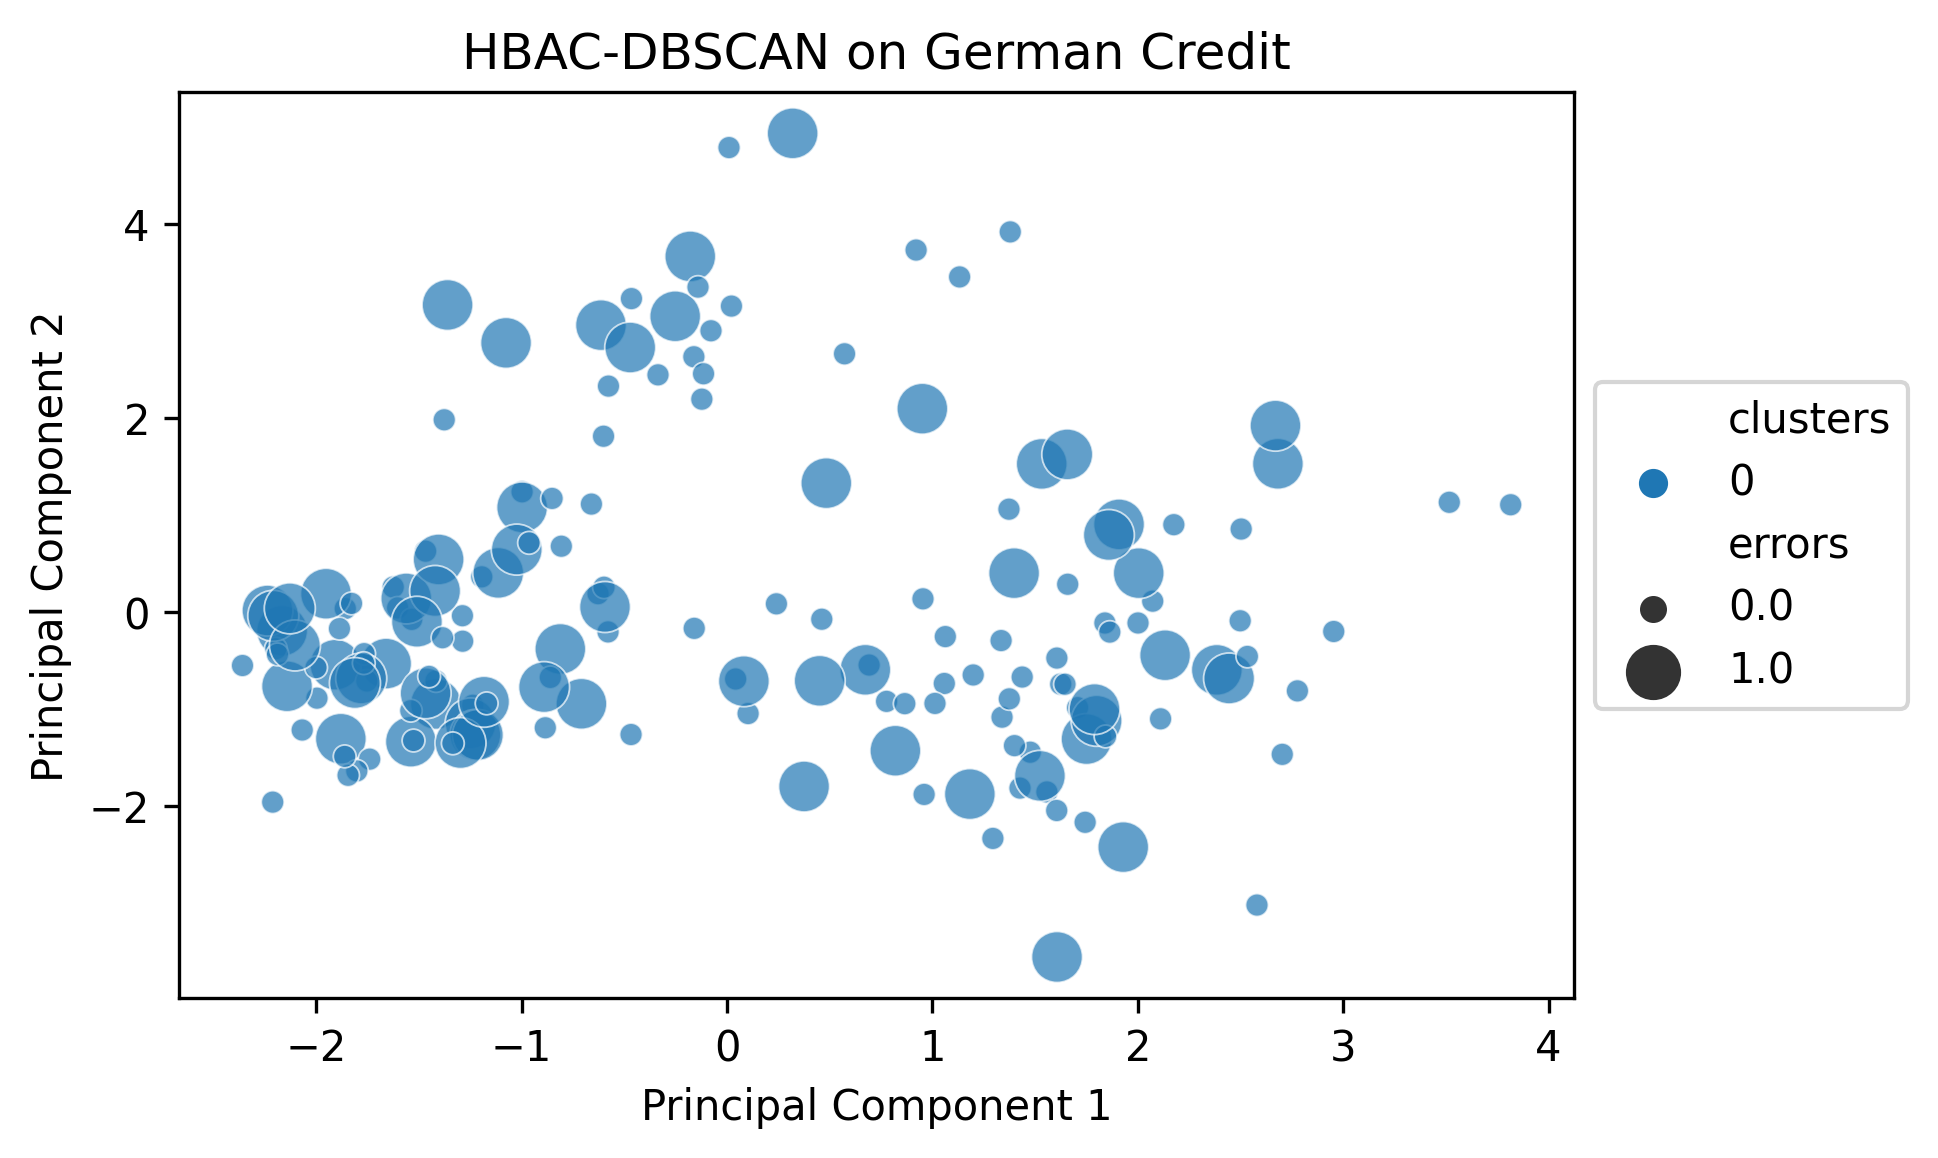

this is the current cluster:  0
discriminating bias is: -999999
smallest cluster:  5


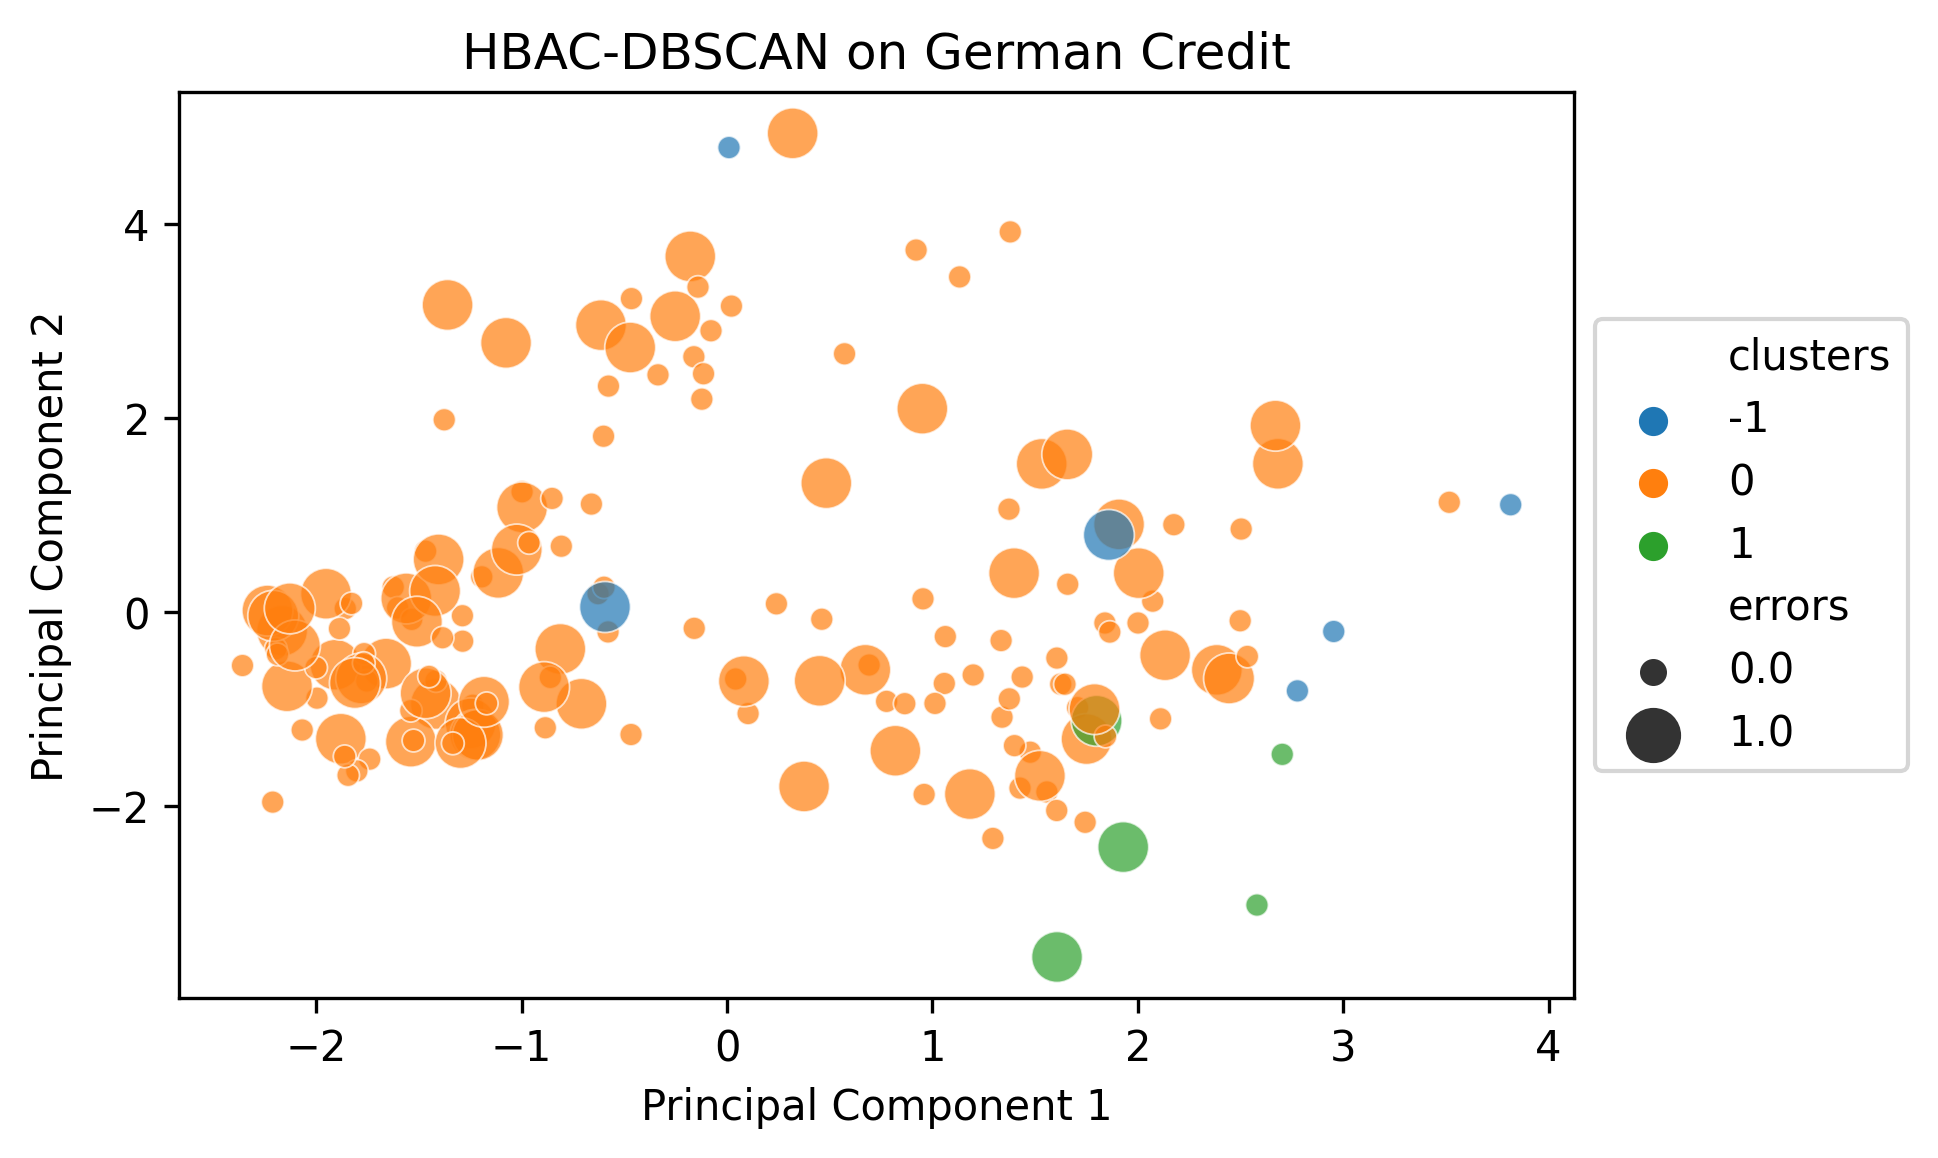

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
MAX_ITER
0.62721893491

In [6]:
MAX_ITER = 30
epsilon = 6.5
minimum_samples = 3 # round(0.02 * len(full_data)) # 2*dim?
x = 0 # cluster number
initial_bias = 0
pca_plot(full_data, 'HBAC-DBSCAN on German Credit', 0.7)
variance_list = []
minimal_splittable_cluster_size = round(0.02 * len(full_data))
minimal_acceptable_cluster_size = round(0.02 * len(full_data))
average_accuracy = accuracy(full_data)

for i in range(1, MAX_ITER):
    print('this is the current cluster: ', x)
    epsilon = epsilon + 0.001
    if len(full_data['clusters'].unique()) != 1:
        variance_list.append(calculate_variance(full_data))

    full_data['new_clusters'] = -2
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply DBSCAN
    candidate_cluster['new_clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
    
    if (len(full_data['new_clusters'].unique()) <= 2): # to check whether a new cluster is found
        continue

    max_neg_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster: ", min_new_size)
    
    if (max_neg_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #>
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        # print(full_data['new_clusters'])
        
        first = True
        dif = 1
        for clstr in full_data['new_clusters'].unique():
            if (clstr == -1):
                full_data['clusters'][full_data['new_clusters'] == clstr] = -1
            elif (clstr == -2):
                continue
            elif first:
                full_data['clusters'][full_data['new_clusters'] == clstr] = x
                first = False
            else:
                full_data['clusters'][full_data['new_clusters'] == clstr] =  n_cluster + dif
                dif += 1

        pca_plot(full_data, 'HBAC-DBSCAN on German Credit', 0.7)
        x = get_next_cluster(full_data)
        initial_bias = max_neg_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')
print(average_accuracy)
print(variance_list)

## Analysing the biased cluster

In [7]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
# print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"cluster {c} has the highest discrimination bias")
print(most_biased_cluster_kmeans_aware)

0 has bias 0.08745684695051792
1 has bias -0.23414634146341462
cluster with the highest discriminating bias: 1
General accuracy of classifier on this dataset: 0.6272189349112426
cluster 1 has the highest discrimination bias
-0.23414634146341462


Number of instances in discriminated cluster: 5
Number of errors in discriminated clusters:  3
found discriminated cluster:


,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
96,2.362129,0.222911,-0.456094,-0.677698,-0.602414,-0.077152,3.987480,-0.547723,-0.620682,-0.109435,...,-0.250785,-0.800485,-0.761209,5.212165,0.0,0,0.0,0.0,1,0.0
137,2.817837,-1.346756,-0.938144,-0.677698,-0.602414,-0.077152,-0.250785,-0.547723,1.611131,-0.109435,...,-0.250785,-0.800485,-0.761209,5.212165,0.8,0,1.0,1.0,1,0.0
213,2.817837,1.792578,-0.496330,0.785437,-0.602414,-0.077152,-0.250785,-0.547723,-0.620682,-0.109435,...,3.987480,-0.800485,-0.761209,5.212165,0.8,0,1.0,1.0,1,0.0
29,2.544412,0.222911,1.410204,3.223996,-0.602414,-0.077152,-0.250785,-0.547723,-0.620682,-0.109435,...,-0.250785,-0.800485,-0.761209,5.212165,0.8,0,1.0,1.0,1,0.0
0,2.908978,0.222911,-0.782232,-1.165410,-0.602414,-0.077152,-0.250785,-0.547723,1.611131,-0.109435,...,-0.250785,-0.800485,-0.761209,5.212165,0.0,0,0.0,0.0,1,0.0


Age
this is the t-statistic 22.349832059720814
this is the p-value: 6.455589196561175e-09
Job
this is the t-statistic 0.45712248253697424
this is the p-value: 0.6702270546834539
Credit amount
this is the t-statistic -0.6017751802923105
this is the p-value: 0.5777720279822074
Duration
this is the t-statistic 0.38111252234710047
this is the p-value: 0.7221680105092939
Purpose_car
this is the t-statistic -7.851028942895632
this is the p-value: 5.207088128827631e-13
Purpose_domestic appliances
this is the t-statistic -0.9999999999999997
this is the p-value: 0.31879271169654194
Purpose_education
this is the t-statistic 0.722740757530959
this is the p-value: 0.5092460052225066
Purpose_furniture/equipment
this is the t-statistic -7.131339285155348
this is the p-value: 3.07182512518737e-11
Purpose_radio/TV
this is the t-statistic 0.5076582893520033
this is the p-value: 0.6374040880333207
Purpose_repairs
this is the t-statistic -1.4185717038670782
this is the p-value: 0.1579330965297679
Purpose

,unscaled_discriminated,unscaled_remaining,difference
Age,64.6,34.182927,30.417073
Job,2.0,1.853659,0.146341
Credit amount,2538.2,3210.810976,-672.610976
Duration,24.0,20.225610,3.774390
Purpose_car,0.0,0.274390,-0.274390
Purpose_domestic appliances,0.0,0.006098,-0.006098
Purpose_education,0.2,0.054878,0.145122
Purpose_furniture/equipment,0.0,0.237805,-0.237805
Purpose_radio/TV,0.4,0.274390,0.125610
Purpose_repairs,0.0,0.012195,-0.012195


,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Check_moderate,Check_no_inf,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior,predicted_class,true_class,errors,index
unscaled_discriminated,64.600000,2.000000,2538.200000,24.00000,0.00000,0.000000,0.200000,0.000000,0.40000,0.000000,...,0.200000,0.200000,0.200000,0.000000,0.000000,1.000000,0.000000,0.600000,0.600000,unscaled_discriminated
unscaled_remaining,34.182927,1.853659,3210.810976,20.22561,0.27439,0.006098,0.054878,0.237805,0.27439,0.012195,...,0.304878,0.396341,0.054878,0.402439,0.378049,0.006098,0.182927,0.256098,0.365854,unscaled_remaining


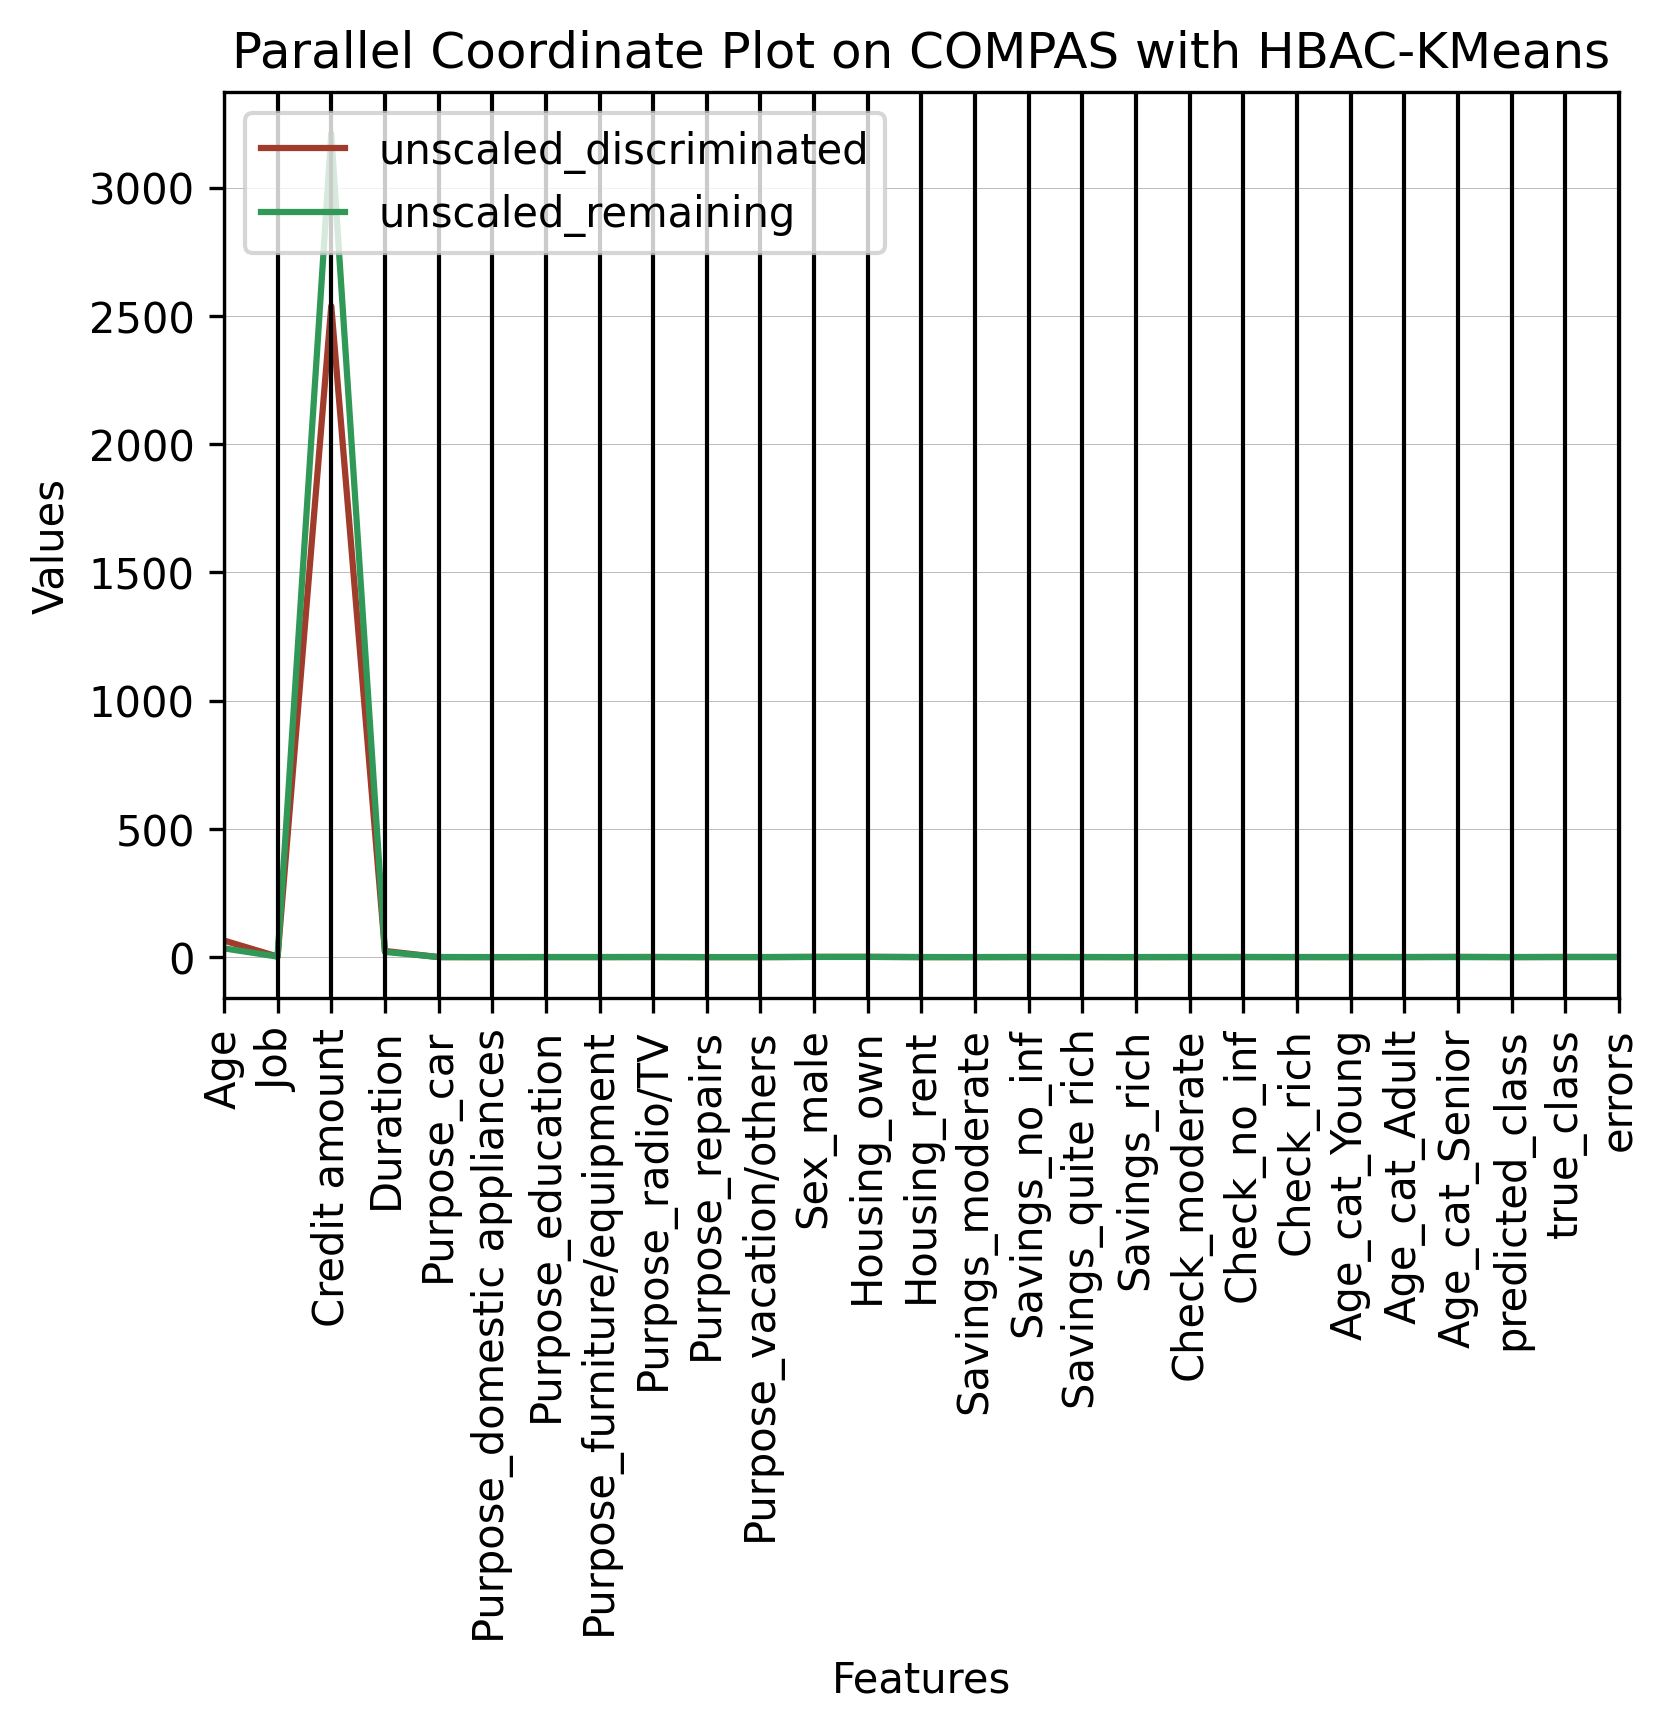

In [8]:
discriminated_cluster = full_data[full_data['clusters']==c]

# results 
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)

# unscaling the clusters
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]
# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

# Welch's test 
for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the t-statistic', welch_i.statistic)
    print('this is the p-value:', welch_i.pvalue)


# Creating DF with mean difference between features
mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
display(mean_clusters)


# creating df for parallel coordinate plot
df_parallel = pd.DataFrame()
df_parallel['unscaled_discriminated'] = unscaled_discriminated.mean()
df_parallel['unscaled_remaining'] = unscaled_remaining.mean()
# df_parallel['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
df_parallel_transpose = df_parallel.T
df_parallel_transpose['index'] = df_parallel_transpose.index
display(df_parallel_transpose.head())

# create parallel coordinate plot
def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(df_parallel_transpose, "Parallel Coordinate Plot on COMPAS with HBAC-KMeans")

## Seaborn Density Plots

In [10]:
# df with discriminated and remaining clusters 

df_all = raw_data.copy(deep=True)
df_all["bias"] = "remaining"
#original_preprocessed[original_preprocessed.index in bias_index, "analysis_plot"] = "biased"

discriminated = df_all.loc[discriminated_cluster.index]
discriminated["bias"] = "discriminated"
df_all["bias"] = discriminated["bias"].combine_first(df_all['bias'])

# check to find discriminated instances in df
df_all.loc[df_all['bias']=='discriminated']


,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Check_moderate,Check_no_inf,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior,predicted_class,true_class,errors,bias
96,61,2,2012,12,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0.0,0.0,discriminated
137,66,1,766,12,0,0,0,0,1,0,...,1,0,0,0,0,1,0,1.0,1.0,discriminated
213,66,3,1908,30,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1.0,1.0,discriminated
29,63,2,6836,60,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1.0,1.0,discriminated
0,67,2,1169,6,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0.0,0.0,discriminated


In [17]:
df_all.columns
welchtest = pd.DataFrame()
# welchtest = df_all[['Age', 'Job', 'Credit amount', 'Duration', 'bias']]
welchtest = df_all
welchtest.columns

Index(['Age', 'Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Savings_moderate', 'Savings_no_inf', 'Savings_quite rich',
       'Savings_rich', 'Check_moderate', 'Check_no_inf', 'Check_rich',
       'Age_cat_Young', 'Age_cat_Adult', 'Age_cat_Senior', 'predicted_class',
       'true_class', 'errors', 'bias'],
      dtype='object')

1
2
3
4


TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

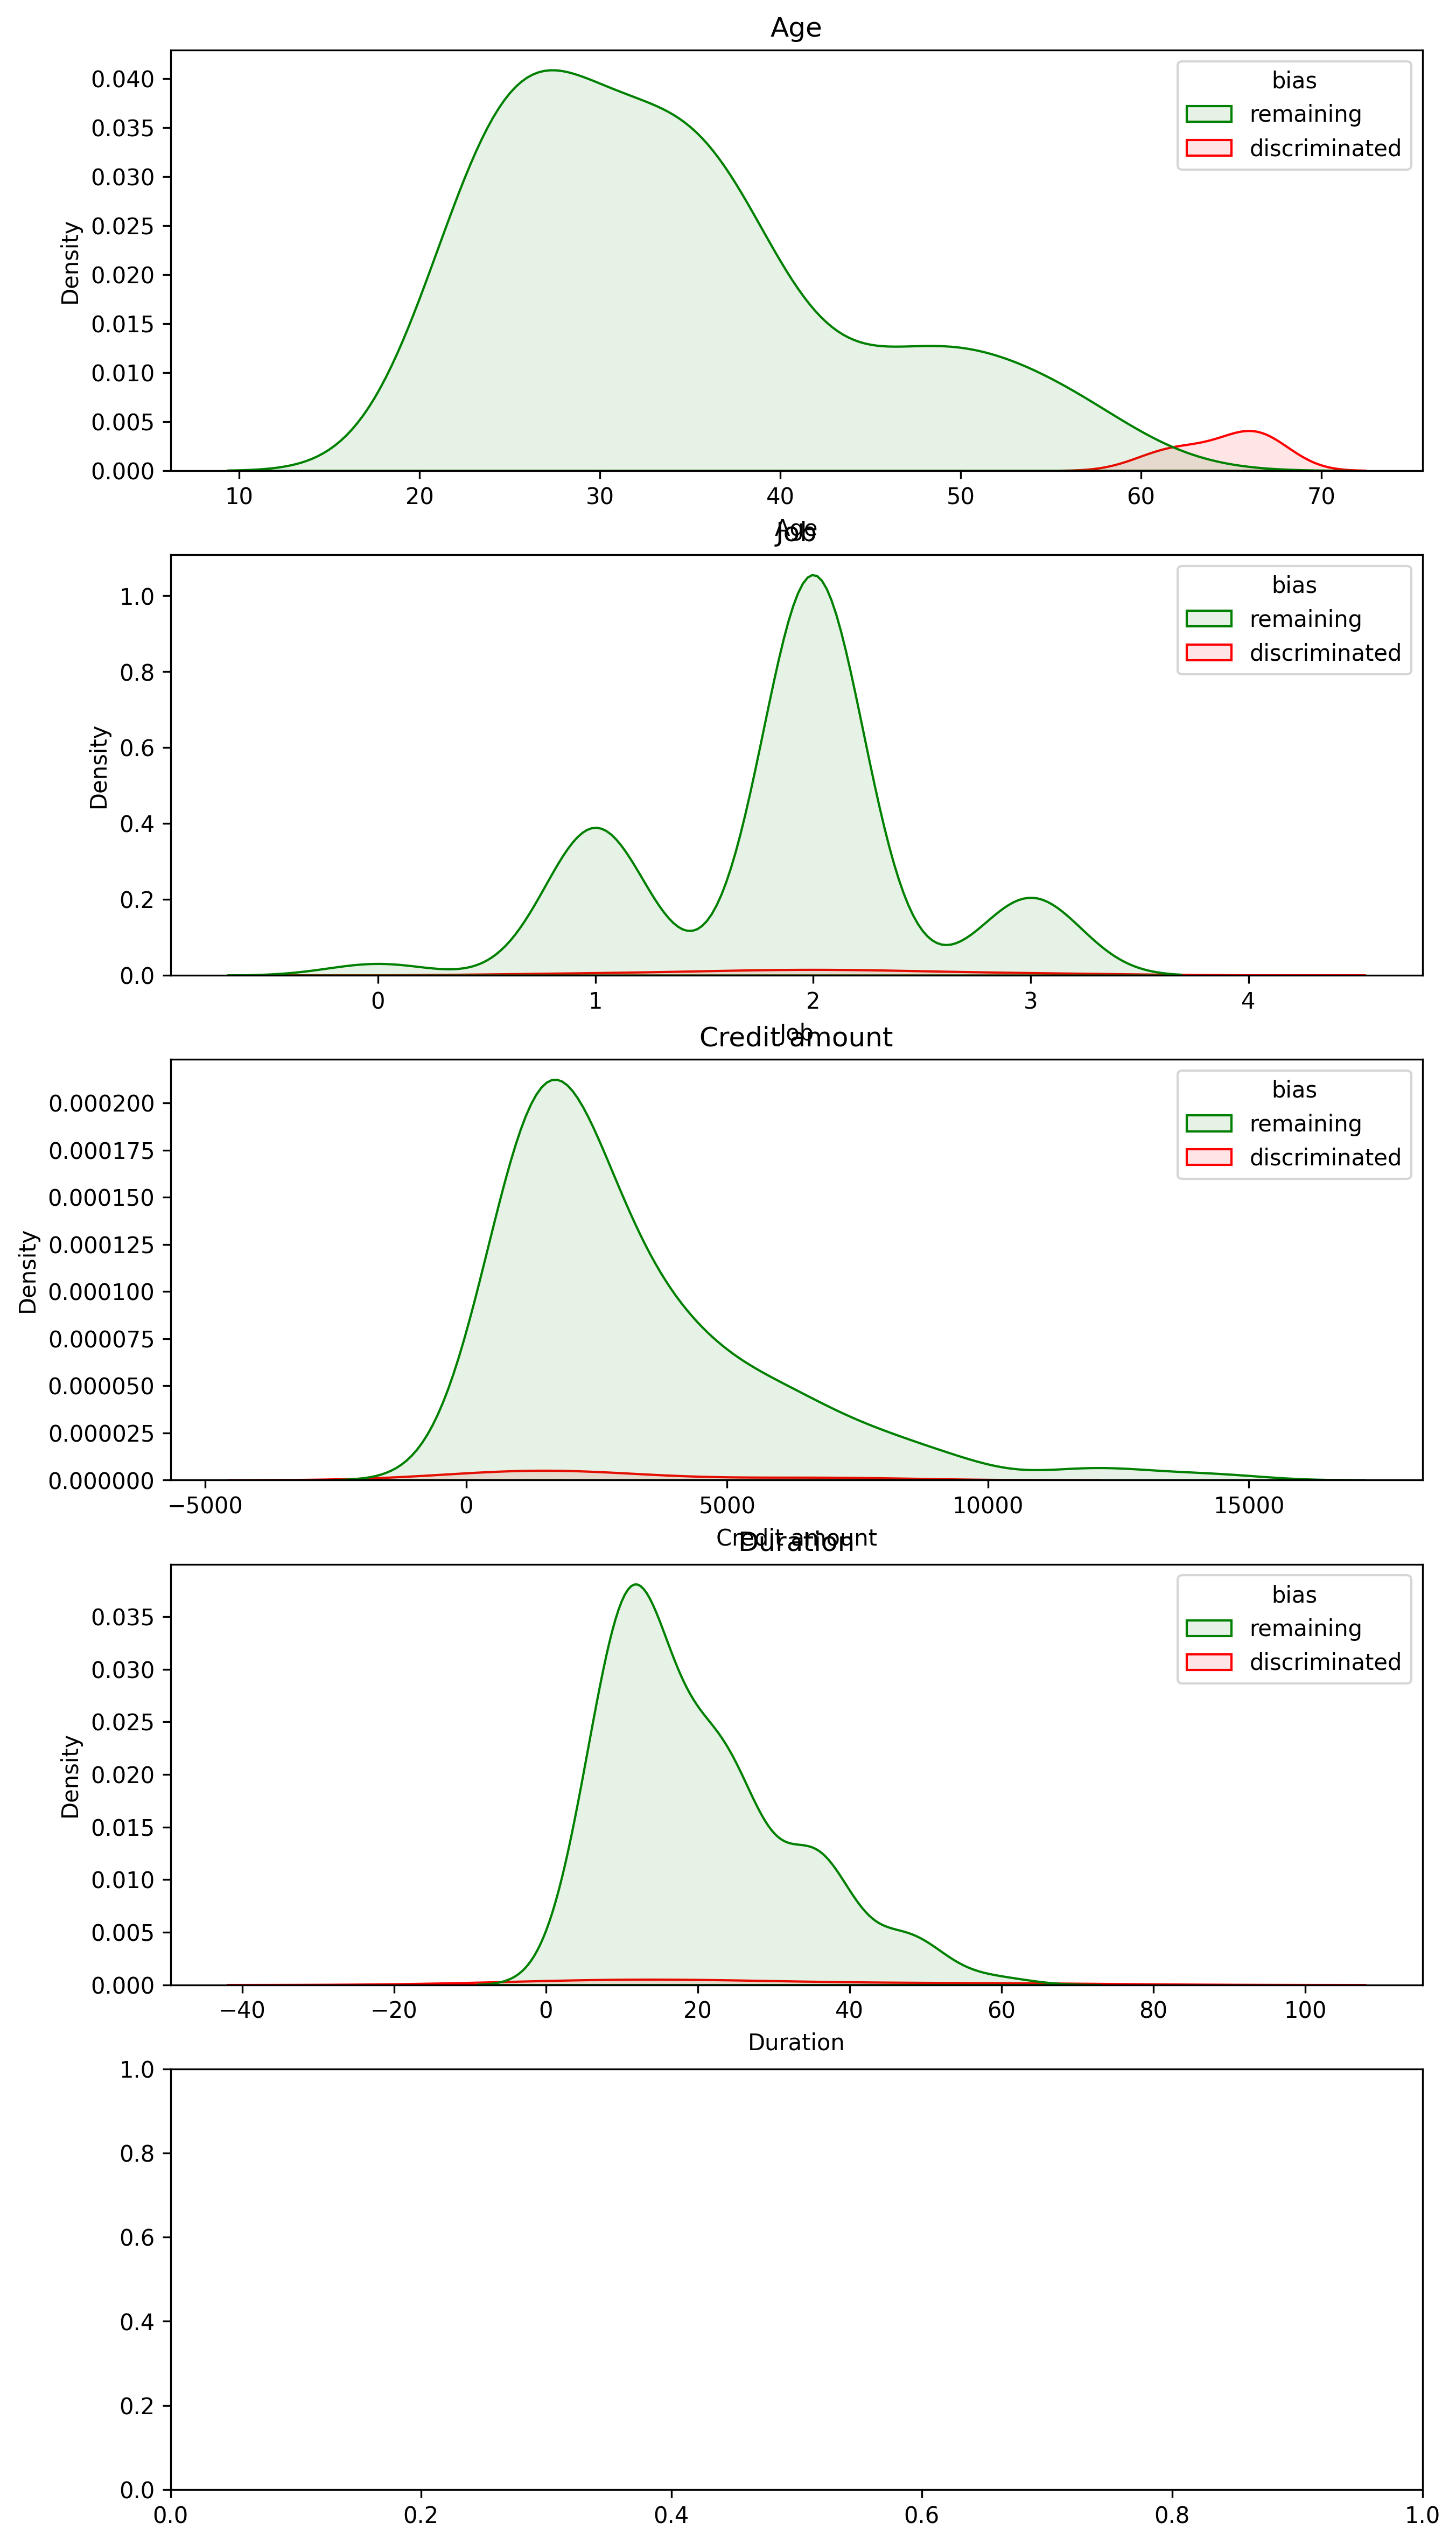

In [16]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,20))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in welchtest.columns:
    sns.kdeplot(data=welchtest, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], palette=my_pal, alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col, fontsize=12) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 5: 
        break

plt.tight_layout()

plt.show()



1
2


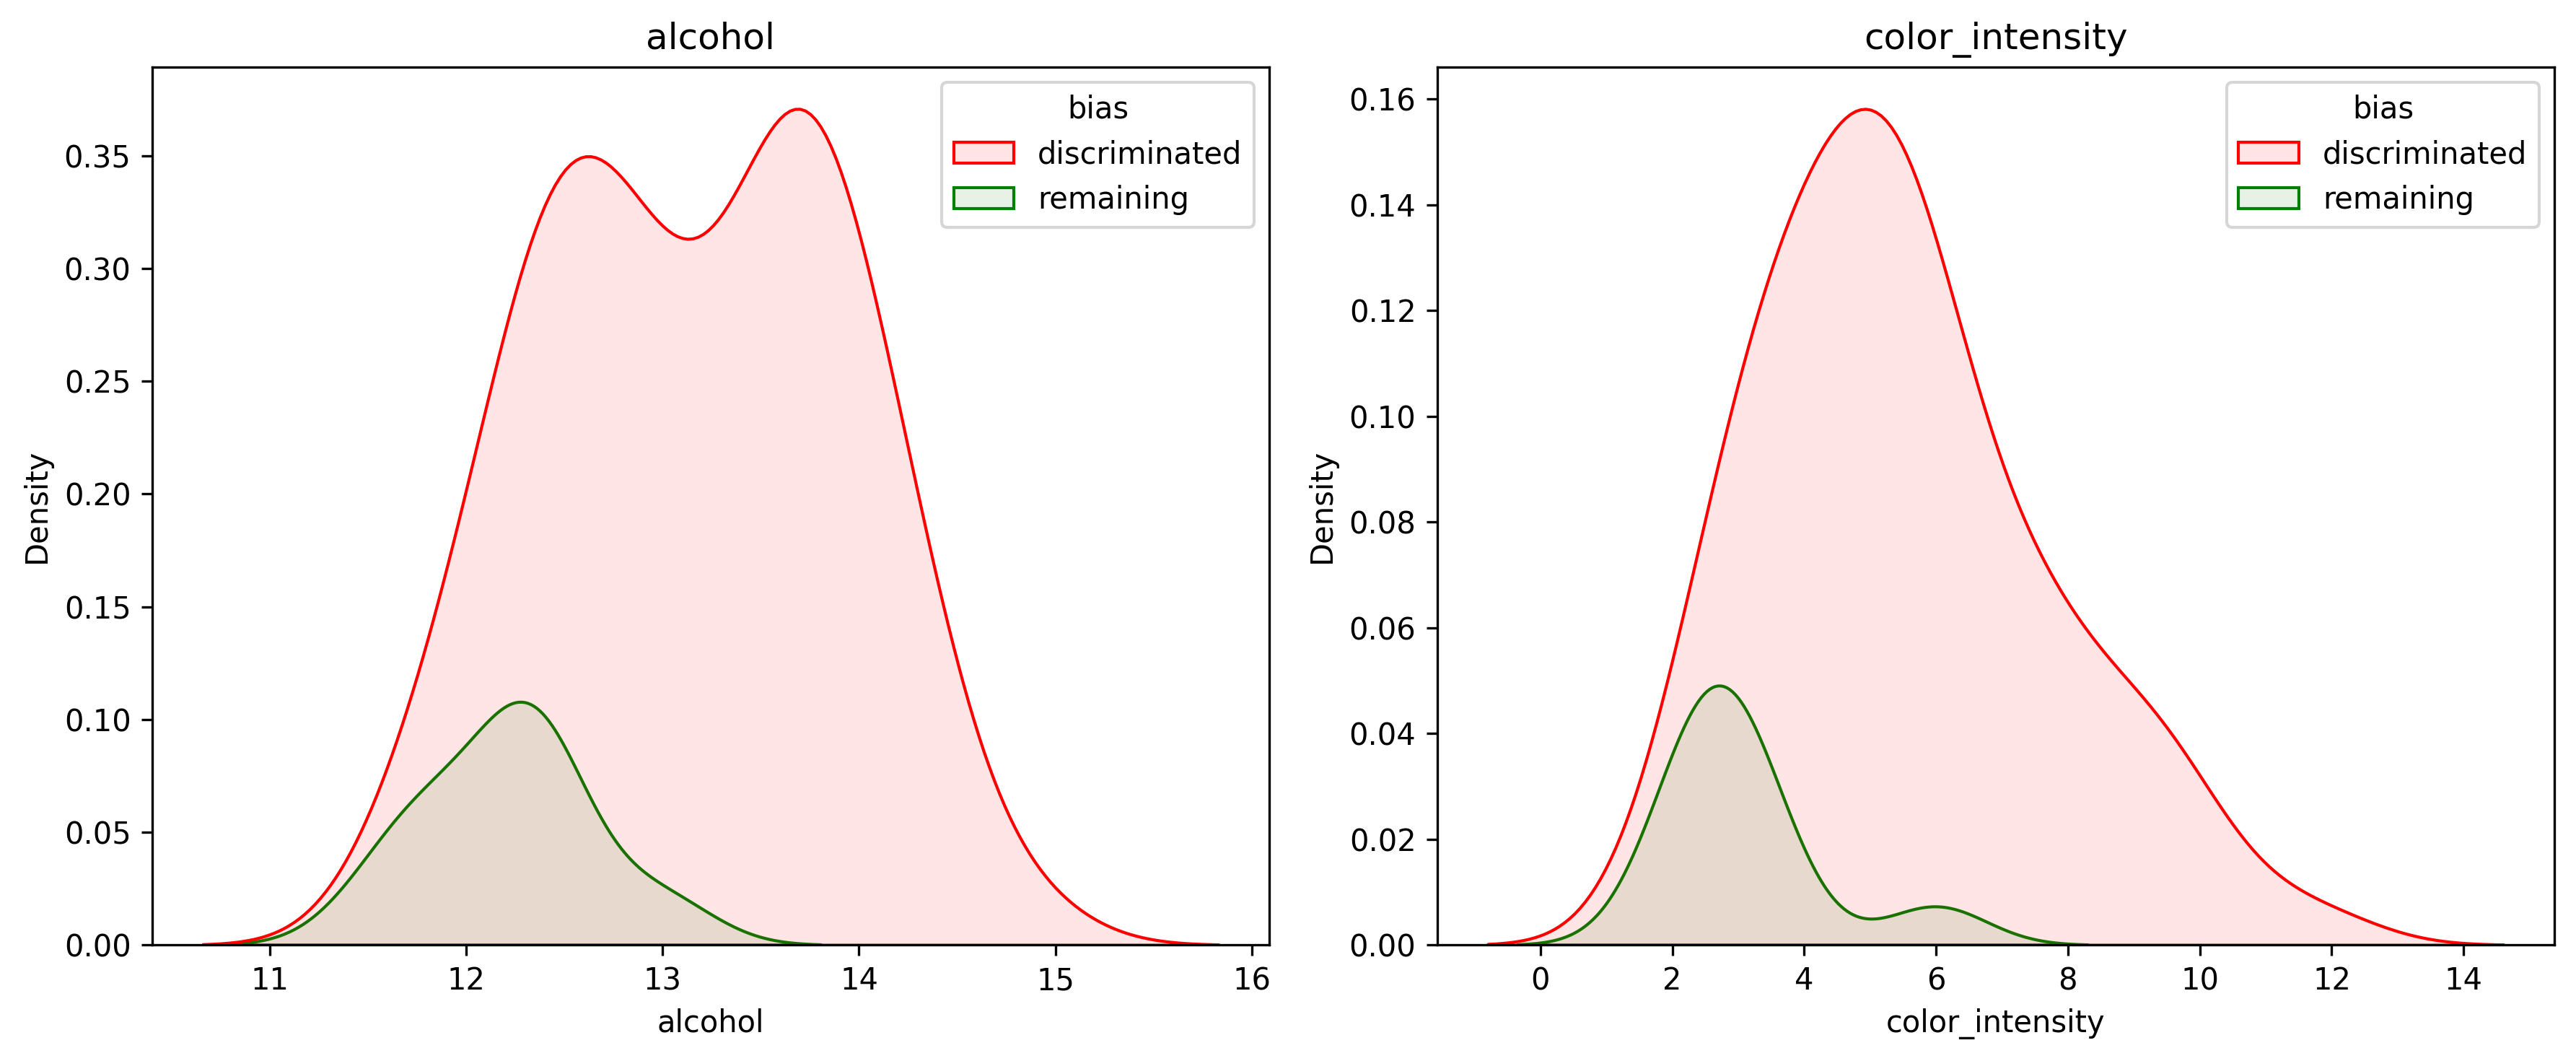

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in welchtest.columns:
    sns.kdeplot(data=welchtest, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], palette=my_pal, alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col, fontsize=12) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 2: 
        break

plt.tight_layout()

plt.show()


## Plotly 

In [22]:
# df with discriminated and remaining clusters 

df_all = raw_data.copy(deep=True)
df_all["bias"] = "remaining"
#original_preprocessed[original_preprocessed.index in bias_index, "analysis_plot"] = "biased"

discriminated = df_all.loc[discriminated_cluster.index]
discriminated["bias"] = "discriminated"
df_all["bias"] = discriminated["bias"].combine_first(df_all['bias'])

# check to find discriminated instances in df
df_all.loc[df_all['bias']=='discriminated']


,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,predicted_class,true_class,errors,bias
3195,2,0,0,0,0,0,0,0,1,0,1,0,1,1,discriminated
2252,2,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
3679,0,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
2524,1,0,0,1,0,0,0,0,1,0,0,0,1,1,discriminated
5140,2,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,2,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
4258,2,0,0,0,0,0,0,0,1,0,1,0,0,0,discriminated
6078,0,0,0,0,0,0,0,0,1,0,1,0,0,0,discriminated
4175,0,1,0,0,0,0,0,0,1,0,0,1,1,0,discriminated


In [19]:
import plotly.figure_factory as ff
import numpy as np

x1 = np.random.randn(200)
x2 = np.random.randn(200) + 2

group_labels = ['Group 1', 'Group 2']

colors = ['slategray', 'magenta']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([x1, x2], group_labels, bin_size=.5,
                         curve_type='normal', # override default 'kde'
                         colors=colors)

# Add title
fig.update_layout(title_text='Distplot with Normal Distribution')
fig.show()

## Seaborn Pairplot / Density plot

In [22]:
sns.pairplot(df_all, hue="bias")

MemoryError: In RendererAgg: Out of memory

MemoryError: In RendererAgg: Out of memory

<Figure size 12433.4x12000 with 272 Axes>